Images dataset link: https://huggingface.co/datasets/BangumiBase/jojonokimyounabouken/blob/main/all.zip <br>
Place the images in the <i>jojo_image_dataset</i> folder (OR) import directly from huggingface

In [ ]:
from sentence_transformers import SentenceTransformer
from diffusers import StableDiffusionPipeline
import torch

# Load CLIP model for prompt expansion
clip_model = SentenceTransformer('clip-ViT-B-32')

# Load Stable Diffusion model for image generation
device = "cuda" if torch.cuda.is_available() else "cpu"
sd_pipeline = StableDiffusionPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5",
    torch_dtype=torch.float32       # change to float16 if using a GPU
).to(device)

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

In [ ]:
import os
from glob import glob
import numpy as np
from langchain_community.vectorstores import FAISS
from langchain_core.documents import Document
from PIL import Image, ImageDraw, ImageFont

def generate_image_embeddings(images_path):
    """
    Generate embeddings for JoJo-style reference images using CLIP.

    Args:
        images_path (str): Path to the directory containing reference images.

    Returns:
        tuple: (numpy array of embeddings, list of documents, list of image paths)
    """
    image_paths = glob(os.path.join(images_path, '**/*.png'), recursive=True)
    embeddings = []
    docs = []

    for img_path in image_paths:
        # Load image and convert to RGB
        image = Image.open(img_path).convert("RGB")
        # Generate CLIP embedding for the image
        embedding = clip_model.encode(image, normalize_embeddings=True)
        embeddings.append(embedding)
        # Store the path of the image as a document
        docs.append(Document(page_content=img_path))

    return np.array(embeddings, dtype=np.float32), docs, image_paths


IMAGES_PATH = 'jojo_image_dataset/'
image_embeddings, image_docs, image_paths = generate_image_embeddings(IMAGES_PATH)

# Create FAISS index from embeddings
faiss_store = FAISS.from_embeddings(
    list(zip(image_paths, image_embeddings.tolist())),
    clip_model)

`embedding_function` is expected to be an Embeddings object, support for passing in a function will soon be removed.


In [ ]:
from langchain_core.prompts import ChatPromptTemplate

def expand_prompt(user_prompt):
    """
    Expand user prompt using similarity search from FAISS index.

    Args:
        user_prompt (str): Input text prompt from the user.

    Returns:
        str: Expanded prompt including style details from similar JoJo-style references.
    """
    # Generate embedding for user prompt
    user_embedding = clip_model.encode(user_prompt, normalize_embeddings=True).tolist()
    # Find top 2 similar embeddings from FAISS
    results = faiss_store.similarity_search_by_vector(user_embedding, k=2)

    # Extract similar descriptions (image paths)
    similar_descriptions = [result.page_content for result in results]

    # Define prompt template to enhance style
    prompt_template = ChatPromptTemplate.from_messages([
        ("system", """Create a JoJo-style image with sharp contrasts, surreal backgrounds, 
                      exaggerated anatomy, expressive faces, and vibrant colors. Keep the 
                      style bold and dynamic."""),
        ("user", "{prompt}, {descriptions}")
    ])
    
    # Combine user prompt and similar descriptions
    expanded_prompt = prompt_template.format(
        prompt=user_prompt,
        descriptions=", ".join(similar_descriptions)
    )

    return expanded_prompt

In [4]:
def overlay_text(image, text):
    """
    Overlay text at the bottom of the generated image.

    Args:
        image (PIL.Image): Generated image.
        text (str): Text to overlay.

    Returns:
        PIL.Image: Image with text overlay.
    """
    draw = ImageDraw.Draw(image)
    font = ImageFont.load_default()
    
    # Get size of the text
    bbox = draw.textbbox((0, 0), text, font=font)
    text_width, text_height = bbox[2] - bbox[0], bbox[3] - bbox[1]
    
    # Get image dimensions
    image_width, image_height = image.size
    
    # Calculate position at bottom center
    x = (image_width - text_width) // 2
    y = image_height - text_height - 10
    
    # Draw black rectangle for contrast
    draw.rectangle(
        [x - 5, y - 5, x + text_width + 5, y + text_height + 5],
        fill=(0, 0, 0)
    )
    
    # Draw white text
    draw.text((x, y), text, font=font, fill=(255, 255, 255))
    
    return image

In [5]:
def generate_image(user_prompt):
    """
    Generate an image from the user prompt using Stable Diffusion.

    Args:
        user_prompt (str): Input text prompt from the user.

    Returns:
        PIL.Image: Generated image with text overlay.
    """
    # Expand prompt to match JoJo style
    expanded_prompt = expand_prompt(user_prompt)

    # Generate image using Stable Diffusion
    generated_image = sd_pipeline(expanded_prompt).images[0]
    
    # Overlay text on generated image
    final_image = overlay_text(generated_image, user_prompt)

    return final_image

def generate_batch(user_prompts, output_dir):
    """
    Generate and save a batch of images from a list of user prompts.

    Args:
        user_prompts (list): List of user input prompts.
        output_dir (str): Directory to save generated images.

    Returns:
        None
    """
    os.makedirs(output_dir, exist_ok=True)

    for i, prompt in enumerate(user_prompts):
        print(f"Generating for prompt {i + 1}/{len(user_prompts)}: {prompt}")
        # Generate image from prompt
        final_image = generate_image(prompt)
        # Save generated image to output directory
        output_path = os.path.join(output_dir, f"generated_image_{i + 1}.png")
        final_image.save(output_path)
        print(f"Saved to: {output_path}")

In [ ]:
user_prompts = [
    "pink elephant walking on the surface of the moon",
    "trees with frogs for leaves",
    "vending machine spreading toxic fumes"
]

# Generate images
generate_batch(user_prompts, output_dir="output_images")



Generating for prompt 1/3: pink elephant walking on the surface of the moon


  0%|          | 0/50 [00:00<?, ?it/s]

Saved to: output_images\generated_image_1.png
Generating for prompt 2/3: trees with frogs for leaves


  0%|          | 0/50 [00:00<?, ?it/s]

Saved to: output_images\generated_image_2.png
Generating for prompt 3/3: vending machine spreading toxic fumes


  0%|          | 0/50 [00:00<?, ?it/s]

Saved to: output_images\generated_image_3.png


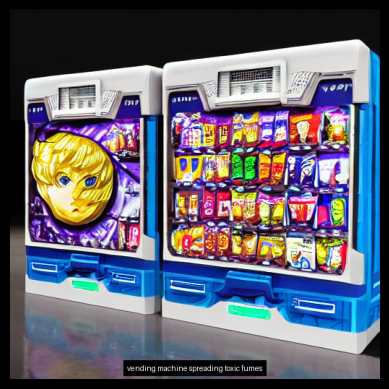

In [21]:
import matplotlib.pyplot as plt
from PIL import Image

num = 3
image = Image.open(f"output_images/generated_image_{num}.png")

plt.imshow(image)
plt.axis(False)
plt.show()